In [1]:
# %pip install torch pymystem3 matplotlib lgbt

In [1]:
import torch
import torch.nn as nn
import re
from lgbt import lgbt
from pymystem3 import Mystem
import matplotlib.pyplot as plt
from collections import defaultdict
# from collections import Counter

In [2]:
device = torch.device("cpu")
print(f"Using device: {device}")

epochs = 10

Using device: cpu


In [3]:
text = open("The_Fellowship_Of_The_Ring.txt", "r").read()
text = text.replace("\n", " ")
text = re.sub(r'[^a-z@# ]', '', text.lower())
text = re.sub(r'[0-9]', ' ', text)

m = Mystem()
lemmatized = m.lemmatize(text)
text = ''.join(lemmatized)

sentences = text.split('.')
window_size = 2

# Построение словаря
words = []
for sentence in sentences:
    if len(sentence) >= window_size * 2 + 1:
        # Обработка предложения
        clean_sentence = re.sub(r'\W+', ' ', sentence).strip()
        if clean_sentence:
            spl = clean_sentence.split()
            words.append(spl)

# Создаем словарь уникальных слов
word_dict = {}
index = 0
for sentence in words:
    for word in sentence:
        if word not in word_dict:
            word_dict[word] = index
            index += 1

# Обратная маппировка для проверки
bacov = {v: k for k, v in word_dict.items()}

# Создание датасета
dataset = []
for sentence in words:
    for i in range(window_size, len(sentence) - window_size):
        target_word = sentence[i]
        context_words = (
            sentence[i - window_size : i] + 
            sentence[i + 1 : i + window_size + 1]
        )
        
        # Проверка наличия всех слов в словаре
        try:
            dataset.append((
                torch.tensor(word_dict[target_word]),  # Целевое слово
                torch.tensor([word_dict[w] for w in context_words])  # Контекст
            ))
        except KeyError as e:
            print(f"Пропущено слово: {e}")
            continue

# Разделение данных
total = len(dataset)
train_size = int(0.8 * total)
val_size = int(0.05 * total)

indices = torch.randperm(total)
train = [dataset[i] for i in indices[:train_size]]
validation = [dataset[i] for i in indices[train_size:train_size+val_size]]
test = [dataset[i] for i in indices[train_size+val_size:]]

print(f"Всего примеров: {total}")
print(f"Размеры выборок: Train={len(train)}, Val={len(validation)}, Test={len(test)}")

Всего примеров: 187222
Размеры выборок: Train=149777, Val=9361, Test=28084


In [6]:
def train_model (model, optimizer, criterion, train_data):
    losses = []
    for epoch in range(epochs):
        cnt = 0
        loss_epoch = 0

        train_bar = lgbt(train_data, desc=f'Epoch {epoch+1}', hero = 'kitten')

        for pair in train_bar:
            optimizer.zero_grad()

            # output = model.forward(pair[1].to(device))
            # loss = criterion(output,pair[0].to(device))

            output = model.forward(pair[0].to(device))
            loss = criterion(output,pair[1].to(device))
            
            loss.backward()

            optimizer.step()
            loss_epoch += loss.item()
            cnt += 1

        loss_epoch /= cnt
        losses.append(loss_epoch)
        print(f'Epoch {epoch+1}/{epochs}: Loss train = {loss_epoch}') 
    return losses

In [7]:
def plot_losses (arr):
    plt.figure()
    plt.plot(arr)
    plt.title('Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

In [8]:
def summarize(word1, word2, dict):
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    UK_RF_148 = dict[word1] + dict[word2]
    mindist = 1000000000
    cnt = 0
    for word in dict.keys():
        if cos(dict[word],UK_RF_148) < mindist:
            mindist = cos(dict[word],UK_RF_148)
            mini = word
        cnt+=1
    return mini

In [9]:
def get_closest(vec, dict):
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    mindist = 1000000000
    for word in dict.keys():
        if cos(dict[word],vec) < mindist:
            mindist = cos(dict[word],vec)
            mini = word
    return mini

In [33]:
dataset = []

for sentence in words:
    for i in range(window_size,len(sentence)-window_size):
        target = torch.zeros(len(word_dict))
        target[word_dict[sentence[i]]] = 1
        target = target.type(torch.LongTensor)
        context = []
        for j in range(i-window_size,i+window_size+1):
            if j == i:
                continue
            context.append(word_dict[sentence[j]])
        context = torch.tensor(context)
        dataset.append((target,context))


pivot = int(0.8*len(dataset))
train = dataset[:pivot]
test = dataset[pivot:]

pivot = int(0.05*len(dataset))
validation = test[:pivot]
test = test[pivot:]

In [34]:
class Word2VecCBOWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2VecCBOWModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.out_layer = nn.Linear(embedding_dim, vocab_size)
        self.activation_function = nn.LogSoftmax(dim=0)

    def forward(self, center_word_idx):
        hidden_layer = torch.mean(self.embeddings(center_word_idx), dim=1)
        out_layer = self.out_layer(hidden_layer)
        log_probs = self.activation_function(out_layer)
        return log_probs

In [35]:
w2v_cbow = Word2VecCBOWModel(len(word_dict),window_size*2).to(device)
criterion = nn.NLLLoss().to(device)
optimizer = torch.optim.SGD(w2v_cbow.parameters(), lr=0.001)

In [41]:
loss_arr = train_model (w2v_cbow, optimizer, criterion, train)

🐱Epoch 1     :100% ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋[149760/149777] [52.77s, 2837.76it/s]  6it/s]  
Epoch 1/10: Loss train = 0.04392569514674426
🐱Epoch 2     :100% ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋[149760/149777] [52.96s, 2827.56it/s]  8it/s]  
Epoch 2/10: Loss train = 0.04226424396683304
🐱Epoch 3     :100% ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋[149760/149777] [53.18s, 2815.95it/s]  2it/s]  
Epoch 3/10: Loss train = 0.040818330919716476
🐱Epoch 4     :100% ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋[149760/149777] [53.14s, 2818.03it/s]  0it/s]  
Epoch 4/10: Loss train = 0.039436400898270454
🐱Epoch 5     :100% ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋[149760/149777] [52.96s, 2827.61it/s]  1it/s]  
Epoch 5/10: Loss train = 0.0380782988864956
🐱Epoch 6     :100% ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋[149760/149777] [53.04s, 2823.55it/s]  9it/s]  
Epoch 6/10: Loss train = 0.036730760

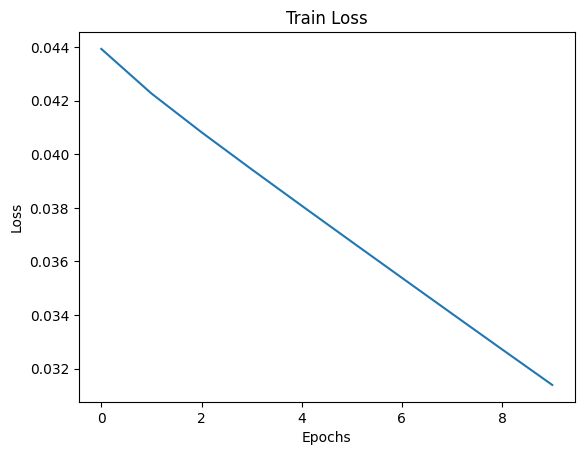

In [42]:
plot_losses (loss_arr)

In [43]:
out = w2v_cbow.forward(train[0][1].to(device))

embeddings = w2v_cbow.embeddings.weight.data.cpu()
w2v_dict = {bacov[ix]: embeddings[ix] for ix in range(len(word_dict))}

w2v_dict.keys()

dict_keys(['this', 'tale', 'grew', 'in', 'the', 'telling', 'until', 'it', 'became', 'a', 'history', 'of', 'great', 'war', 'ring', 'and', 'included', 'many', 'glimpses', 'yet', 'more', 'ancient', 'that', 'preceded', 'was', 'begun', 'soon', 'after', 'hobbit', 'written', 'before', 'its', 'publication', 'but', 'i', 'did', 'not', 'go', 'on', 'with', 'sequel', 'for', 'wished', 'first', 'to', 'complete', 'set', 'order', 'mythology', 'legends', 'elder', 'days', 'which', 'had', 'then', 'been', 'taking', 'shape', 'some', 'years', 'desired', 'do', 'my', 'own', 'satisfaction', 'little', 'hope', 'other', 'people', 'would', 'be', 'interested', 'work', 'especially', 'since', 'primarily', 'linguistic', 'inspiration', 'provide', 'necessary', 'background', 'elvish', 'tongues', 'when', 'those', 'whose', 'advice', 'opinion', 'sought', 'corrected', 'no', 'went', 'back', 'encouraged', 'by', 'requests', 'from', 'readers', 'information', 'concerning', 'hobbits', 'their', 'adventures', 'story', 'drawn', 'irres

In [ ]:
print (summarize ('beauty', 'change', w2v_dict),
       summarize ('beautiful', 'colour', w2v_dict), 
       summarize ('till', 'never', w2v_dict),
       summarize ('really', 'shines', w2v_dict),
       summarize ('anxiety', 'judge', w2v_dict),
       get_closest (w2v_dict['back'] + w2v_dict['vanish'], w2v_dict),
       sep='\n')

conjuror
supple
smallest
tidy
past
calmly


In [45]:
device = torch.device("cuda")
print(f"Using device: {device}")

Using device: cuda


In [10]:
dataset2 = []

for sentence in words:
    for i in range(window_size,len(sentence)-window_size):
        target = torch.tensor(word_dict[sentence[i]])
        context = torch.zeros(len(word_dict))

        for j in range(i-window_size,i+window_size+1):
            if j == i:
                continue
            context[word_dict[sentence[j]]] = 1

        context = context.type(torch.LongTensor)
        dataset2.append((target,context))

pivot = int(0.8*len(dataset2))
train = dataset2[:pivot]
test = dataset2[pivot:]

pivot = int(0.05*len(dataset2))
validation = test[:pivot]
test = test[pivot:]

In [11]:
class Word2VecSkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2VecSkipGramModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.out_layer = nn.Linear(embedding_dim, vocab_size)
        self.activation_function = nn.LogSoftmax(dim=-1)

    def forward(self, center_word_idx):
        hidden_layer = self.embeddings(center_word_idx)
        out_layer = self.out_layer(hidden_layer)
        log_probs = self.activation_function(out_layer)
        return log_probs

In [12]:
w2v_SGM = Word2VecSkipGramModel(len(word_dict),4).to(device)
criterion = nn.NLLLoss().to(device)
optimizer = torch.optim.SGD(w2v_SGM.parameters(), lr=0.05)

In [13]:
loss_arr = train_model (w2v_SGM, optimizer, criterion, train)

🐱Epoch 1     :100% ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋[149760/149777] [46.58s, 3215.09it/s]  7it/s]  
Epoch 1/10: Loss train = 0.07618106869836662
🐱Epoch 2     :100% ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋[149760/149777] [45.74s, 3274.07it/s]  2it/s]  
Epoch 2/10: Loss train = 0.06278054075326675
🐱Epoch 3     :100% ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋[149760/149777] [45.95s, 3259.44it/s]  1it/s]  
Epoch 3/10: Loss train = 0.06248328207770484
🐱Epoch 4     :100% ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋[149760/149777] [45.47s, 3293.93it/s]  6it/s]  
Epoch 4/10: Loss train = 0.062216050981950086
🐱Epoch 5     :100% ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋[149760/149777] [46.24s, 3238.62it/s]  9it/s]  
Epoch 5/10: Loss train = 0.061941745380492026
🐱Epoch 6     :100% ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋[149760/149777] [45.98s, 3257.38it/s]  6it/s]  
Epoch 6/10: Loss train = 0.06165988

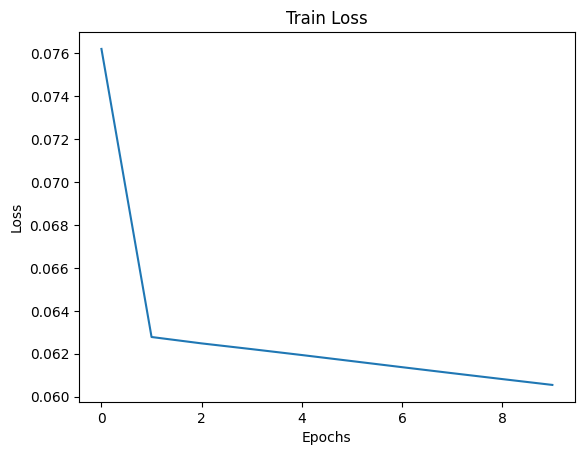

In [14]:
plot_losses (loss_arr)

In [15]:
embeddings2 = w2v_SGM.embeddings.weight.data.cpu()
w2v_dict2 = {bacov[ix]: embeddings2[ix] for ix in range(len(word_dict))}

w2v_dict2.keys()

dict_keys(['this', 'tale', 'grew', 'in', 'the', 'telling', 'until', 'it', 'became', 'a', 'history', 'of', 'great', 'war', 'ring', 'and', 'included', 'many', 'glimpses', 'yet', 'more', 'ancient', 'that', 'preceded', 'was', 'begun', 'soon', 'after', 'hobbit', 'written', 'before', 'its', 'publication', 'but', 'i', 'did', 'not', 'go', 'on', 'with', 'sequel', 'for', 'wished', 'first', 'to', 'complete', 'set', 'order', 'mythology', 'legends', 'elder', 'days', 'which', 'had', 'then', 'been', 'taking', 'shape', 'some', 'years', 'desired', 'do', 'my', 'own', 'satisfaction', 'little', 'hope', 'other', 'people', 'would', 'be', 'interested', 'work', 'especially', 'since', 'primarily', 'linguistic', 'inspiration', 'provide', 'necessary', 'background', 'elvish', 'tongues', 'when', 'those', 'whose', 'advice', 'opinion', 'sought', 'corrected', 'no', 'went', 'back', 'encouraged', 'by', 'requests', 'from', 'readers', 'information', 'concerning', 'hobbits', 'their', 'adventures', 'story', 'drawn', 'irres

In [16]:
print (summarize ('beauty', 'change', w2v_dict2),
       summarize ('beautiful', 'colour', w2v_dict2), 
       summarize ('till', 'never', w2v_dict2),
       summarize ('really', 'shines', w2v_dict2),
       summarize ('anxiety', 'judge', w2v_dict2),
       get_closest (w2v_dict2['back'] + w2v_dict2['vanish'], w2v_dict2),
       sep='\n')

think
emptiness
special
crests
maker
material
